In [1]:
pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 6.8MB 8.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [2]:
# Required Imports
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import glob
import pandas as pd
import math
from imblearn.over_sampling import KMeansSMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from keras import backend as K
# Computing Custom metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
# Loading the data into a DataFrame
all_filenames = [i for i in glob.glob('/content/drive/My Drive/TrainingData/*.{}'.format('csv'))]
df_x, df_x_time, df_y, df_y_time = [], [], [], []
for f in all_filenames:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df_y_time.append(df)
    
x = pd.concat(df_x, ignore_index=True)
x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
x_time = pd.concat(df_x_time, ignore_index=True)
x_time.columns = ['x_time']
y = pd.concat(df_y, ignore_index=True)
y.columns = ['y', 'subject', 'subject_ID']
y_time = pd.concat(df_y_time, ignore_index=True)
y_time.columns = ['y_time']
x['time'] = x_time['x_time']
y['time'] = y_time['y_time']
y['time'] = [round(x+0.005,3) for x in y['time']]

In [6]:
# Merging X and Y and retaining all features
full_df = pd.merge(x,y, on=['time','subject', 'subject_ID'], how='left')

In [7]:
full_df['y'] = full_df['y'].interpolate(method='nearest')
# Dropping nulls
full_df.dropna(inplace=True)

In [8]:
from numpy import array
# Function to split the data points into 40 timesteps
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	end_flag = True
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			end_flag = False
			for j in range(i, len(sequences)):
				seq_x = sequences[j:, :-1]
				if seq_x.shape[0] < n_steps:
					#zero padding
					add_x = np.zeros((n_steps-seq_x.shape[0],6))
					# add_x = sequences[-(n_steps-seq_x.shape[0]):,:-1]
					seq_x = np.r_[seq_x, add_x]
					seq_y = sequences[j, -1]
				X.append(seq_x)
				y.append(seq_y)
			break
    # gather input and output parts of the pattern
		if (end_flag):
			seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
			X.append(seq_x)
			y.append(seq_y)
	return array(X), array(y)

In [9]:
# Dividing the data into groups of Subject and Subject ID
final_X, final_y = list(), list()
for name, group in full_df.groupby(['subject', 'subject_ID']):
  df = group
  in_seq1 = df['x1'].to_numpy().reshape((len(df['x1']), 1))
  in_seq2 = df['x2'].to_numpy().reshape((len(df['x2']), 1))
  in_seq3 = df['x3'].to_numpy().reshape((len(df['x3']), 1))
  in_seq4 = df['x4'].to_numpy().reshape((len(df['x4']), 1))
  in_seq5 = df['x5'].to_numpy().reshape((len(df['x5']), 1))
  in_seq6 = df['x6'].to_numpy().reshape((len(df['x6']), 1))
  out_seq = df['y'].to_numpy().reshape((len(df['y']), 1))
  dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq))
  X, y = split_sequences(dataset, 40)
  final_X.extend(X)
  final_y.extend(y)
X = array(final_X)
y = array(final_y)

In [10]:
ind = np.argwhere(np.isnan(y)).flatten()
allrows = np.array(range(len(X)))
X_n = X[np.setdiff1d(allrows,ind)]
y = y[~np.isnan(y)]
y = y.reshape(-1,1)

In [11]:
unique, counts = np.unique(y, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[1017904   81578   60243  207358]


In [12]:
# Garbage collection to free memory
lst = [[full_df, df, final_X, final_y, X, df_x, df_x_time, df_y, df_y_time, df, in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq, dataset]]
del lst
full_df=pd.DataFrame()
df=pd.DataFrame()
final_X = []
final_y = []
X = []
df_x, df_x_time, df_y, df_y_time = [], [], [], []
df = []
in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq, dataset = [], [], [], [], [], [], [], []

In [23]:
# CNN model
model_CNN = Sequential()

#Adding the input layer with an input shape of flattened timesteps
model_CNN.add(Dense(256, activation= 'relu', input_shape=(1,240)))
#Adding consequetive hidden layers with batch normalization layers with swish activation
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(256, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(128, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(64, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(32, activation= 'swish'))
model_CNN.add(BatchNormalization())
#Adding the Output Layer
model_CNN.add(Dense(4, activation='softmax')) 
#Compiling with SGD optimizer having 0.9 momentum and nesterov momentum
model_CNN.compile(optimizer=SGD(momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_m], sample_weight_mode="temporal")
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 256)            61696     
_________________________________________________________________
dense_9 (Dense)              (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 512)            2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 512)            2048      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 256)           

In [14]:
model_CNN.input_shape

(None, 1, 240)

In [15]:
model_CNN.output_shape

(None, 1, 4)

In [16]:
# Performing a 70:30 split of the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.3, random_state=177)

In [17]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,240))
X_test = scaler.transform(X_test.reshape(-1,240))

In [18]:
# Clearing out memory
lst = [[X_n, y, x, x_time]]
del lst
X_n = []
y = []
x = []
x_time = []

In [22]:
# Over Sampling Classes 1 and 2 using kmeansSMOTE
oversample = KMeansSMOTE(sampling_strategy={1:145000, 2:145000}, cluster_balance_threshold=0.03, k_neighbors=3)
X_train = X_train.reshape(-1,240)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [24]:
# Checking the count of classes after resampling
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[712382 145005 145003 145092]


In [25]:
# Ading class weight parameter in CNN models
class_weights = np.zeros((len(y_train), 4))
class_weights[:, 0] += 1
class_weights[:, 1] += 50
class_weights[:, 2] += 45
class_weights[:, 3] += 10

In [26]:
# Reshape inputs according to input shape
X_train = X_train.reshape(-1,1,240)
X_test = X_test.reshape(-1,1,240)

In [27]:
# Reshape according to model output size
y_train = to_categorical(y_train).reshape(-1,1,4)
y_test = to_categorical(y_test).reshape(-1,1,4)

In [28]:
# Saving best model each time
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/My Drive/CNN911{epoch:08d}.h5', save_best_only=True) 

In [30]:
model_CNN.save('/content/drive/My Drive/CNN911.h5')

In [29]:
# Fitting the model with a batch size of 400 and added class weights for 40 epochs
CNN_history = model_CNN.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=400, sample_weight=class_weights)

Epoch 1/40
2869/2869 [==============================] - 145s 50ms/step - loss: 20.1023 - categorical_accuracy: 0.7205 - f1_m: 0.7139 - val_loss: 0.7056 - val_categorical_accuracy: 0.7505 - val_f1_m: 0.7461
Epoch 2/40
2869/2869 [==============================] - 146s 51ms/step - loss: 16.7456 - categorical_accuracy: 0.7686 - f1_m: 0.7655 - val_loss: 0.6411 - val_categorical_accuracy: 0.7696 - val_f1_m: 0.7670
Epoch 3/40
2869/2869 [==============================] - 146s 51ms/step - loss: 15.0723 - categorical_accuracy: 0.7922 - f1_m: 0.7901 - val_loss: 0.6140 - val_categorical_accuracy: 0.7794 - val_f1_m: 0.7771
Epoch 4/40
2869/2869 [==============================] - 149s 52ms/step - loss: 13.9095 - categorical_accuracy: 0.8078 - f1_m: 0.8063 - val_loss: 0.5921 - val_categorical_accuracy: 0.7878 - val_f1_m: 0.7867
Epoch 5/40
2869/2869 [==============================] - 148s 51ms/step - loss: 13.0189 - categorical_accuracy: 0.8192 - f1_m: 0.8179 - val_loss: 0.5675 - val_categorical_accura

In [ ]:
# Load model if needed
from keras.models import load_model
CNN_model = load_model('/content/drive/My Drive/CNNdnkmfull41100000023.h5', custom_objects={'f1_m': f1_m})

In [ ]:
# Function to split test data into proper inputs
def split_test_sequences(sequences, n_steps):
  X = list()
  end_flag = True 
  for i in range(0,len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      end_flag = False
      for j in range(i, len(sequences)):  
        seq_x = sequences[j:, :]
        if seq_x.shape[0] < n_steps:
          add_x = np.zeros((n_steps-seq_x.shape[0],6))
          seq_x = np.r_[seq_x, add_x]
        X.append(seq_x)
      break
    # gather input and output parts of the pattern
    if (end_flag):
      seq_x = sequences[i:end_ix, :]
      X.append(seq_x)
  return array(X)

In [ ]:
# Code block to transform the test data into inputs and join with y_time to get the prediction at that specific y_time
test_filenames = [i for i in glob.glob('/content/drive/My Drive/TestData/*.{}'.format('csv'))]
df_x, df_x_time, df_y_time = [], [], []
for f in test_filenames:
  if '012' in f:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y_time.append(df)
    
test_x = pd.concat(df_x, ignore_index=True)
test_x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
test_x_time = pd.concat(df_x_time, ignore_index=True)
test_x_time.columns = ['x_time']
test_y_time = pd.concat(df_y_time, ignore_index=True)
test_y_time.columns = ['time', 'subject', 'subject_ID']
test_x['time'] = test_x_time['x_time']
test_y_time['time'] = [round(x + 0.005,3) for x in test_y_time['time']]
final_test = pd.merge(test_x, test_y_time, on=['time', 'subject', 'subject_ID'], how='left')
in_seq1 = final_test['x1'].to_numpy().reshape((len(final_test['x1']), 1))
in_seq2 = final_test['x2'].to_numpy().reshape((len(final_test['x2']), 1))
in_seq3 = final_test['x3'].to_numpy().reshape((len(final_test['x3']), 1))
in_seq4 = final_test['x4'].to_numpy().reshape((len(final_test['x4']), 1))
in_seq5 = final_test['x5'].to_numpy().reshape((len(final_test['x5']), 1))
in_seq6 = final_test['x6'].to_numpy().reshape((len(final_test['x6']), 1))
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))
test_x = split_test_sequences(dataset, 40)
test_x = scaler.transform(test_x.reshape(-1,240))
test = test_x.reshape(-1,1,240)
y_pred = CNN_model.predict(test)
y_pred = np.argmax(y_pred.reshape(-1,4), axis=1)
final_test['y_pred'] = y_pred
pred = pd.merge(final_test, test_y_time, on=['time', 'subject', 'subject_ID'], how='inner')['y_pred']
pred.to_csv("subject_012_01__y_prediction.csv", index=False, header=False)

In [31]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

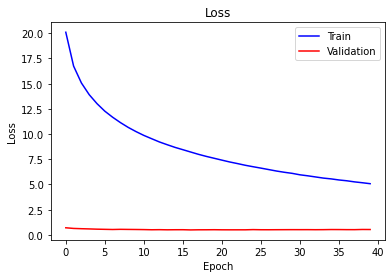

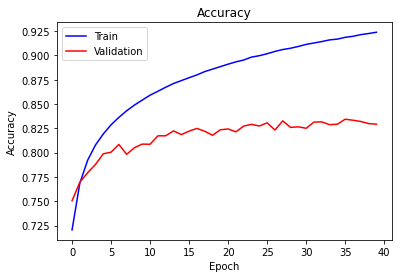

In [32]:
# Plotting the Accuracy and Loss curves
plot_history(CNN_history)

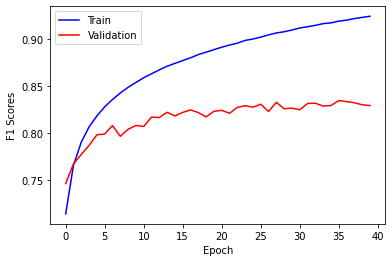

In [36]:
# Plotting f1 metric
plt.plot(CNN_history.history['f1_m'], color='blue', label='train')
plt.plot(CNN_history.history['val_f1_m'], color='red', label='test')
plt.ylabel('F1 Scores')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

In [35]:
# Classification report for the model on the test data we split using test_train_split
from sklearn.metrics import classification_report
y_p = model_CNN.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89    305522
           1       0.64      0.56      0.60     24315
           2       0.54      0.51      0.53     18022
           3       0.70      0.65      0.68     62266

    accuracy                           0.83    410125
   macro avg       0.69      0.66      0.67    410125
weighted avg       0.82      0.83      0.83    410125

